In [1]:
import random
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import pandas as pd
import glob
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# KGE avg

In [16]:
df_latlon=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/Magni-PCR-GLOBWB-RF-NEW/source/data/stationLatLon.csv')

sub1= pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/OUTPUT_MAGNI/RF/3_validate/subsample_1/KGE_allpredictors.csv')
sub2= pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/OUTPUT_MAGNI/RF/3_validate/subsample_2/KGE_allpredictors.csv')
sub3= pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/OUTPUT_MAGNI/RF/3_validate/subsample_3/KGE_allpredictors.csv')
sub4= pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/OUTPUT_MAGNI/RF/3_validate/subsample_4/KGE_allpredictors.csv')
sub5= pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/OUTPUT_MAGNI/RF/3_validate/subsample_5/KGE_allpredictors.csv')

# create one big df 
KGE_subs= pd.concat([sub1, sub2, sub3, sub4, sub5])

KGE_mean = KGE_subs.groupby(['grdc_no'])['KGE_corrected'].mean().reset_index()
# save KGE_MEAN to csv
KGE_mean.to_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/OUTPUT_MAGNI/RF/3_validate/KGE_mean_cum.csv')

# new column if KGE is above -0.41 = 1, else 0
KGE_mean['performance_binary'] = KGE_mean['KGE_corrected'].apply(lambda x: 1 if x > -0.41 else 0)
print(len(KGE_mean))
print(KGE_mean['performance_binary'].value_counts())
print(round(174/len(KGE_mean),3), 'percentage of stations with KGE > -0.41')

267
1    173
0     94
Name: performance_binary, dtype: int64
0.652 percentage of stations with KGE > -0.41


## correlation analysis

In [116]:
df_zero=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/df_corr_calc.csv')
# inner join df_zero and KGE_mean
df_zero_KGE = pd.merge(df_zero, KGE_mean, on='grdc_no', how='inner')
df_zero_KGE = df_zero_KGE[df_zero_KGE['obs'] != 0]
# check correlation between KGE_corrected and obs
df_zero_KGE['KGE_corrected'].corr(df_zero_KGE['obs'])
# do a pearson correlation test
from scipy.stats import pearsonr
corr, p_value = pearsonr(df_zero_KGE['KGE_corrected'], df_zero_KGE['obs'])
print('Pearsons correlation: %.3f' % corr)
print('p-value: %.3f' % p_value)

Pearsons correlation: -0.309
p-value: 0.005


/var/folders/cy/m0ghrt5529lf66_4rgd0s2mw0000gn/T/ipykernel_50526/166417862.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


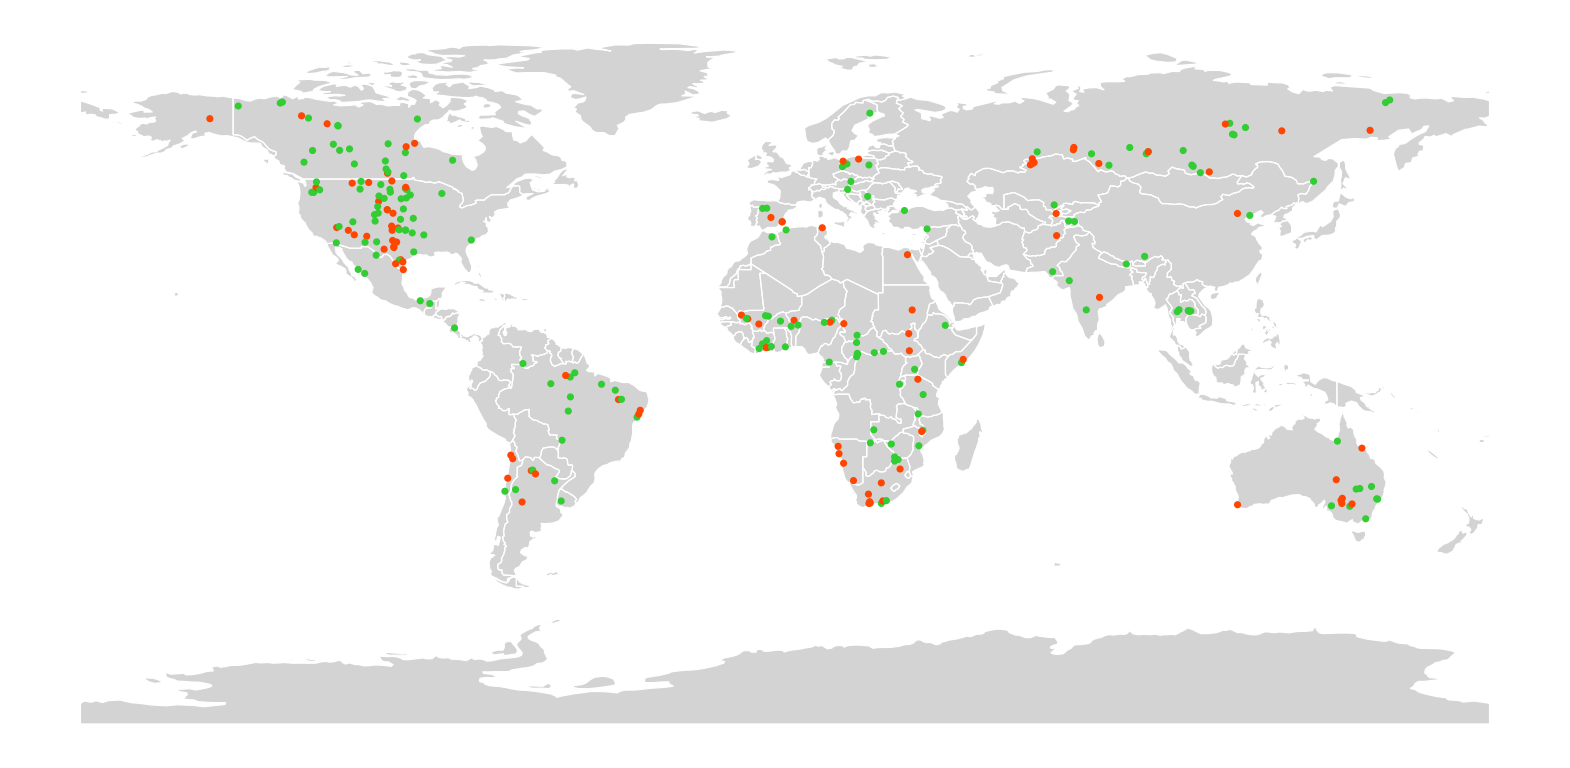

In [123]:
# Plot the stations on a map
# Inner join to get the lat lon
KGE_mean_latlon = pd.merge(KGE_mean, df_latlon, on='grdc_no', how='inner')

# Create a geodataframe
gdf = gpd.GeoDataFrame(KGE_mean_latlon, geometry=gpd.points_from_xy(KGE_mean_latlon.lon, KGE_mean_latlon.lat))

# Manually assign colors to performance_binary values
color_dict = {0: 'orangered', 1: 'limegreen'}
gdf['color'] = gdf['performance_binary'].map(color_dict)

# set size of the points
gdf['size'] = 17

# Define the figure size
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the world map as the basemap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgray')

# Plot the geodataframe with manually assigned colors
gdf.plot(color=gdf['color'], markersize=gdf['size'], legend=True, ax=ax, zorder=2)

# Plot the boundary lines on top of the dots
world.boundary.plot(ax=ax, color='white', linewidth=0.9, zorder=1)

# Set the plot title
plt.axis('off')
plt.show()


# Boxplots of binary outlier differences

In [4]:
bigtable=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/bigtable_ALL_low.csv')
bigtable['Filename']= bigtable['Filename'].str.replace('pcr_allpredictors_|.csv', '', regex=True)
bigtable['Filename']= bigtable['Filename'].astype(int)

KGE_mean_0= KGE_mean[KGE_mean['performance_binary']==0]
KGE_mean_1= KGE_mean[KGE_mean['performance_binary']==1]
# inner join bigtable with KGE_mean_0
bigtable_0= pd.merge(bigtable, KGE_mean_0, left_on='Filename',right_on='grdc_no', how='inner')
bigtable_1= pd.merge(bigtable, KGE_mean_1, left_on='Filename',right_on='grdc_no', how='inner')
# save bigtable_0
bigtable_0.to_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/bigtable_0.csv')
bigtable_1.to_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/bigtable_1.csv')
print(len(bigtable_0))
print(len(bigtable_1))
print(len(bigtable_0)+len(bigtable_1),'=',len(bigtable))

42166
79313
121479 = 145523


In [115]:
def count_outliers(df):

    # Create an empty series to store outlier counts
    outlier_counts = pd.Series(dtype=int)

    # Loop over each column in the dataframe
    for column in df.columns:
        # Calculate the z-score for each value in the column
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())

        # Count the number of outliers in the column
        num_outliers = (z_scores > 3).sum()

        # Store the outlier count in the series
        outlier_counts[column] = num_outliers

    return outlier_counts
# bigtable_0= bigtable_0.drop(['datetime','Group'], axis=1)
# bigtable_1= bigtable_1.drop(['datetime','Group'], axis=1)
all_0=count_outliers(bigtable_0)/len(bigtable_0)*100
all_1=count_outliers(bigtable_1)/len(bigtable_1)*100
# put both in one df
all_0= pd.DataFrame(all_0)
all_1= pd.DataFrame(all_1)
# put them all in seperate columns, inner join on index
all_outliers= pd.merge(all_0, all_1, left_index=True, right_index=True, how='inner')
all_outliers= all_outliers.rename(columns={'0_x':'0','0_y':'1'})
all_outliers.head(15)
# calculate the difference in percentage
all_outliers['difference']= all_outliers['0']-all_outliers['1']
# check how many times 0 is higher than 1
all_outliers.head(15)

,0,1,difference
obs,0.934356,1.341143,-0.406787
pcr,1.069077,2.341700,-1.272623
precipitation,1.240738,0.976702,0.264036
temperature,0.002173,0.010602,-0.008429
referencePotET,0.000000,0.010602,-0.010602
desalinationAbstraction,4.708720,3.905484,0.803236
surfaceWaterInf,1.284196,1.496197,-0.212000
snowCoverSWE,1.440647,1.555832,-0.115186
directRunoff,1.768758,1.774497,-0.005739
snowFreeWater,1.799179,2.274113,-0.474934


# all variable analysis

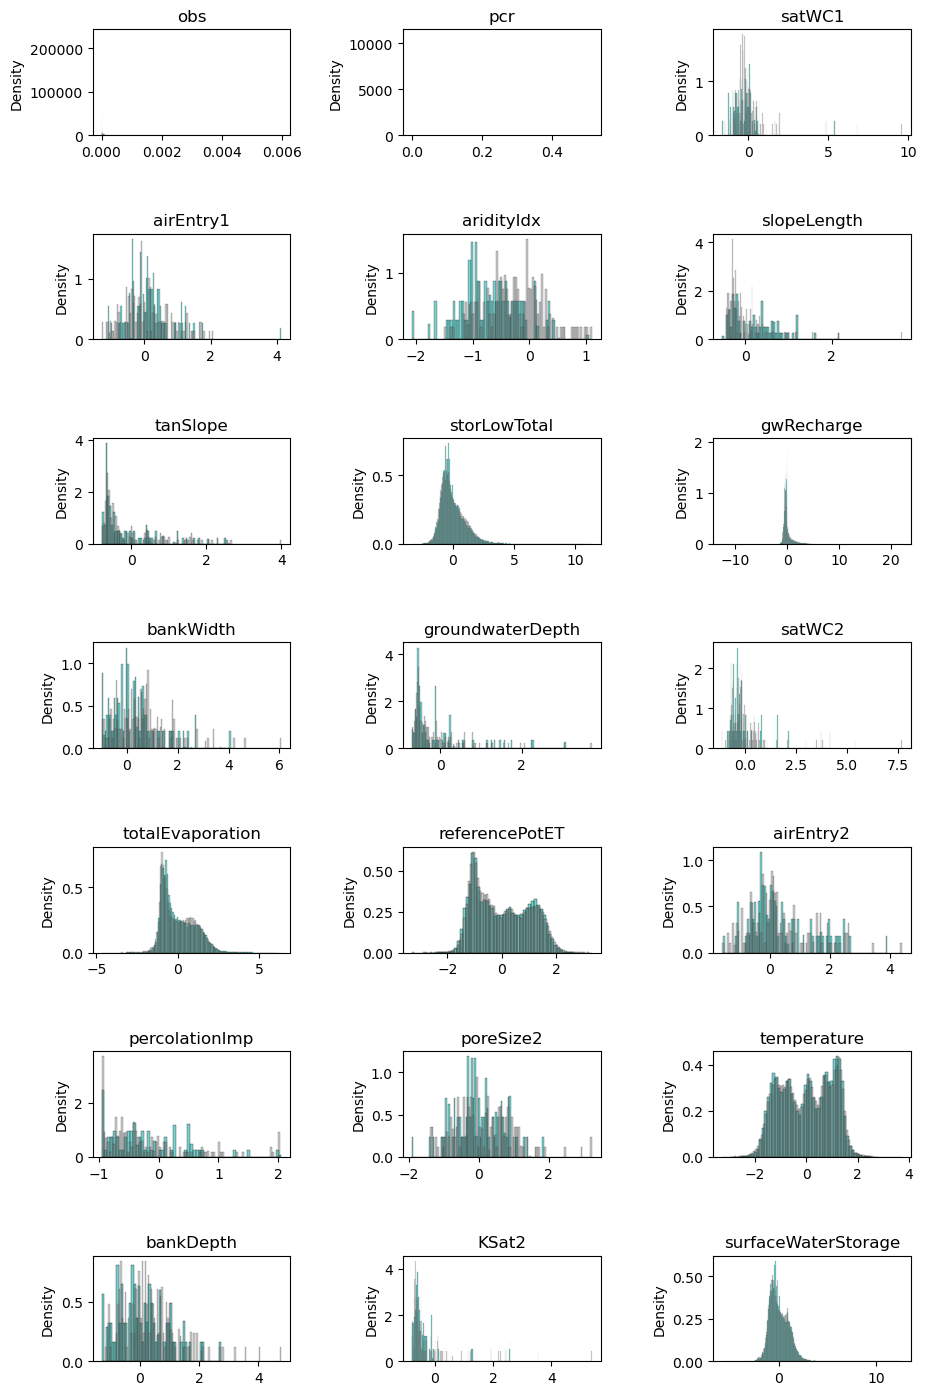

In [124]:
# only plot distribution of important predictors
bigtable_0_imp=bigtable_0[['obs','pcr','satWC1','airEntry1','aridityIdx','slopeLength','tanSlope','storLowTotal','gwRecharge','bankWidth','groundwaterDepth','satWC2','totalEvaporation','referencePotET','airEntry2','percolationImp','poreSize2','temperature','bankDepth','KSat2','surfaceWaterStorage']]

bigtable_1_imp=bigtable_1[['obs','pcr','satWC1','airEntry1','aridityIdx','slopeLength','tanSlope','storLowTotal','gwRecharge','bankWidth','groundwaterDepth','satWC2','totalEvaporation','referencePotET','airEntry2','percolationImp','poreSize2','temperature','bankDepth','KSat2','surfaceWaterStorage']]
# bigtable_1_imp=bigtable_0_imp.sample(n=46021, random_state=1)

def compare_distributions(df1, df2):
    # Ensure the dataframes have the same columns
    assert df1.columns.tolist() == df2.columns.tolist(), "Dataframes must have the same columns."

    # Create subplots for each column
    num_columns = len(df1.columns)
    num_rows = 7
    num_cols = 3#num_columns // num_rows + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))
    fig.tight_layout(pad=5)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each column and create distribution plots
    for i, column in enumerate(df1.columns):
        ax = axes[i]

        # Plot distribution for df1 # normalised to 1
        sns.histplot(df1[column], ax=ax, label='df1', color='lightseagreen', alpha=0.6, stat='density')

        # Plot distribution for df2
        sns.histplot(df2[column], ax=ax, label='df2', color='grey', alpha=0.4, stat='density')

        # Remove legend
        ax.legend().remove()

        # Set title and variable name below the plot
        ax.set_title(column)
        # remove x label
        ax.set_xlabel('')

    # Hide unused subplots
    for j in range(num_columns, num_rows * num_cols):
        fig.delaxes(axes[j])

    # Display the plots
    plt.show()

compare_distributions(bigtable_0_imp, bigtable_1_imp)

In [5]:
print('Rows in the low performance group:')
print(len(bigtable_0['obs']))
print('NaN values')
print(round(bigtable_0['obs'].isnull().sum()/(len(bigtable_0)),3),'\n')
print('Rows in the high performance group')
print(len(bigtable_1['obs']))
print('NaN values')
print(round(bigtable_1['obs'].isnull().sum()/len(bigtable_1),3))

Rows in the low performance group:
42166
NaN values
0.423 

Rows in the high performance group
79313
NaN values
0.424


In [114]:
print(bigtable_0['obs'].value_counts().head(1))
print(bigtable_1['obs'].value_counts().head(1))
print(3748/len(bigtable_0)*100)
print(1411/len(bigtable_1)*100)
from scipy.stats import ttest_ind

ttest_ind(bigtable_0['obs'], bigtable_1['obs'], nan_policy='omit')



0.0    3748
Name: obs, dtype: int64
0.0    1411
Name: obs, dtype: int64
8.888678081866907
1.7790273977784221


Ttest_indResult(statistic=-72.20550257674384, pvalue=0.0)

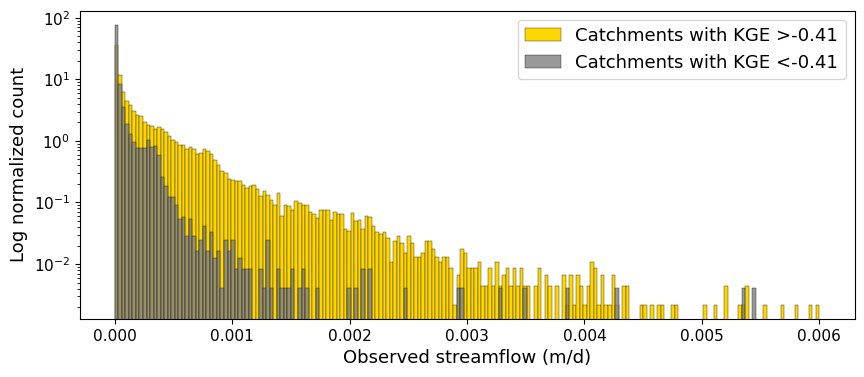

In [120]:
# Creating a histogram to compare the distributions of the "obs" column
fig, ax = plt.subplots(figsize=(10, 4))
binwidth = 0.00003

# Plotting the histogram for "bigtable_1" dataset
sns.histplot(bigtable_1['obs'], ax=ax, label='Catchments with KGE >-0.41', color='gold', alpha=1, binwidth=binwidth, stat='percent')

# Plotting the histogram for "bigtable_0" dataset
sns.histplot(bigtable_0['obs'], ax=ax, label='Catchments with KGE <-0.41', color='grey', alpha=0.8, binwidth=binwidth, stat='percent')
ax.legend()
# ax.set_title('Comparing distribution of streamflow')
ax.set_xlabel('Observed streamflow (m/d)', fontsize=13)
ax.set_ylabel('Log normalized count', fontsize=13)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=11)
ax.legend(fontsize=13)
plt.show()

/var/folders/cy/m0ghrt5529lf66_4rgd0s2mw0000gn/T/ipykernel_50526/1931119531.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


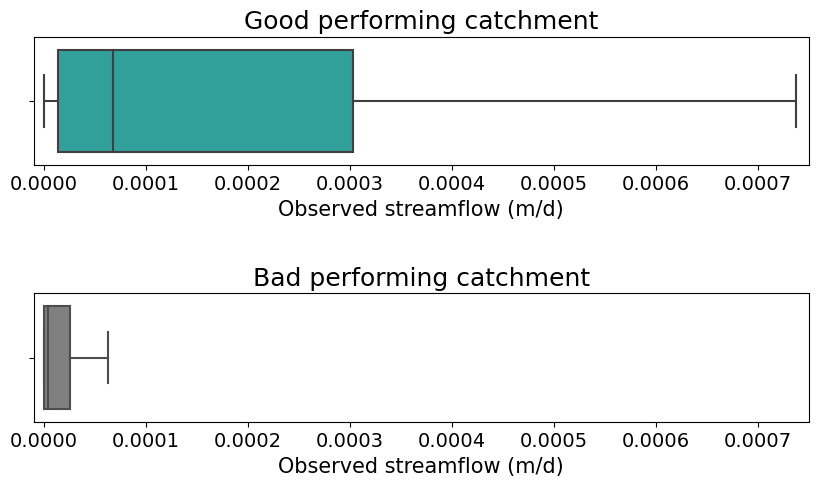

In [125]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=False, gridspec_kw={'hspace': 1})

sns.boxplot(x=bigtable_1['obs'], ax=axes[0], color='lightseagreen', showfliers=False)
sns.boxplot(x=bigtable_0['obs'], ax=axes[1], color='grey', showfliers=False)

axes[0].set_title('Good performing catchment', fontsize=18)
axes[1].set_title('Bad performing catchment', fontsize=18)
axes[1].set_xlabel('Observed streamflow (m/d)', fontsize=15)
axes[0].set_xlabel('Observed streamflow (m/d)', fontsize=15)
axes[0].set_xlim(-0.00001, 0.00075)
axes[1].set_xlim(-0.00001, 0.00075)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()


plt.show()


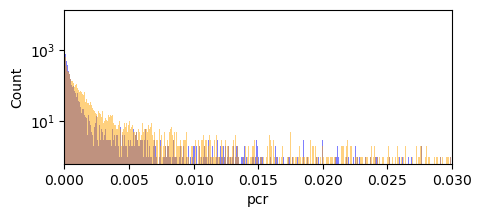

In [118]:
# only compare the distributions of the obs column
fig, ax = plt.subplots(figsize=(5, 2))
sns.histplot(bigtable['pcr'], ax=ax, label='df2', color='orange', alpha=0.5, binwidth=binwidth, stat='percent')
sns.histplot(bigtable_0['pcr'], ax=ax, label='df1', color='blue', alpha=0.7, binwidth=binwidth, stat='percent')
ax.legend().remove()
ax.set_xlabel('pcr')
ax.set_yscale('log')
plt.xlim(0,0.03)
plt.show()

In [147]:
print(bigtable_0['pcr'].max())
print(bigtable_1['pcr'].max())

0.511623038692412
0.105115483489933


In [ ]:
3,  1 4 1 5
  9 2 6 5
  3 5 8 9
  7 9 3 2 